In [2]:
# !pip install transformers
# !pip install keras_nlp
# !pip install datasets
# !pip install huggingface-hub huggingface_hub
# !pip install nltk
# !pip install rouge-score rouge
# !pip install evaluate
# !apt install git-lfs
# !pip install sentencepiece

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from datasets import load_dataset, load_metric, load_from_disk
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, AdamWeightDecay, create_optimizer
from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
from tensorflow.keras.callbacks import TensorBoard
import evaluate
import nltk
from transformers import pipeline, set_seed
set_seed(42)
from nltk.corpus import stopwords
nltk.download('punkt')

# Only log error messages
import logging
tf.get_logger().setLevel(logging.ERROR)

os.environ["TOKENIZERS_PARALLELISM"] = "True"

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/src')
from metrics_evaluation import evaluate_model
from preprocesss import preprocess_function, preprocess_dataset
from tf_datas import prepare_tf_datasets, compile_model, plot_loss

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from huggingface_hub import notebook_login

notebook_login()

## Loading the dataset

### About Dataset
[BIGPATENT](https://huggingface.co/datasets/big_patent), consisting of 1.3 million records of U.S. patent documents along with human written abstractive summaries. Each US patent application is filed under a Cooperative Patent Classification (CPC) code. There are nine such classification categories:

* a: Human Necessities
* b: Performing Operations; Transporting
* c: Chemistry; Metallurgy
* **d: Textiles; Paper**
* e: Fixed Constructions
* f: Mechanical Engineering; Lightning; Heating; Weapons; Blasting
* g: Physics
* h: Electricity
* y: General tagging of new or cross-sectional technology

I will be working with **1** out of the **9** classification categories due to low compute unit.

In [4]:
# df = load_dataset("big_patent", "d")

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
## saving the data
# df.save_to_disk('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d_dataset')

# Loading the data
df = load_from_disk('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d_dataset')

In [4]:
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 10164
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


In [5]:
df['train'] = df['train'].shuffle(seed=42).select(range(5000))
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


## Define Certain Variables

In [6]:
# Maximum length of the input to the model
MAX_INPUT_LENGTH = 1024  

# Minimum length of the output by the model
MIN_TARGET_LENGTH = 5  
# Maximum length of the output by the model
MAX_TARGET_LENGTH = 128 

# Batch-size for training our model
BATCH_SIZE = 8

**Model Input Length**
The maximum length of the input allowed for the model is set to 1024. This means that any input text provided to the model should not exceed this length. If the input text is longer than 1024 characters, it will need to be truncated or shortened before being passed to the model.

**Model Output Length**
The model has specific requirements for the length of the output it generates. The minimum length of the output is set to 5, which means that the model should produce a response with at least 5 characters. On the other hand, the maximum length of the output is set to 128 characters, meaning that the generated output should not exceed this length.

**Training Batch Size**
During the training process, the model operates on data in batches. The batch size determines the number of examples (input-output pairs) processed in each training iteration. In this case, the batch size is set to 8, which means that the model will process 8 examples at a time during training.

## T5-Small

### Preprocessing

In [10]:
MODEL_CHECKPOINT = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

if MODEL_CHECKPOINT in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [11]:
tokenized_df = preprocess_dataset(df, tokenizer, MAX_INPUT_LENGTH, MIN_TARGET_LENGTH, MAX_TARGET_LENGTH, prefix)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

The `preprocess_dataset` function takes in a dataset, a tokenizer, maximum input length, minimum target length, maximum target length, and a prefix. Its purpose is to preprocess the input DataFrame by tokenizing it using Hugging Face Tokenizer and restricting the lengths of input and target sequences based on the provided parameters.

In [12]:
tokenized_df["train"]

Dataset({
    features: ['description', 'abstract', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})

In [13]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [14]:
# Prepare datasets
tf_train_set, tf_val_set, tf_generation_set = prepare_tf_datasets(tokenized_df["train"],
                                                                  tokenized_df["validation"],
                                                                  BATCH_SIZE,
                                                                  tokenizer,
                                                                  model
                                                                )

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The `prepare_tf_datasets` function is responsible for preparing TensorFlow datasets for training, validation, and generation using a pre-trained model. It takes in tokenized training and validation datasets, batch size, tokenizer, and model as input.

Here's how the function works:

1. It initializes two data collators: `data_collator` and `generation_data_collator`. These collators are responsible for collating the tokenized data into batches suitable for training and generation.

2. The `model.prepare_tf_dataset` method is called to prepare the training dataset (`tokenized_train_dataset`), validation dataset (`tokenized_val_dataset`) and generation dataset (`tf_generation_set`). It takes in the respective tokenized datasets (`tokenized_val_dataset` in the case of val & generation datasets), the batch size, and the collate function. For the validation dataset, the shuffle flag is set to `False` to maintain the order of examples during evaluation. For the generation dataset, the collate function is set to `generation_data_collator`, and the `return_tensors` parameter is set to **"np"** to return NumPy arrays instead of TensorFlow tensors.

In [15]:
# Compile the model
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01) 
compile_model(model, optimizer)

In [16]:
# pushing the model to tensorflow hub
model_name = MODEL_CHECKPOINT.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-Big-Patents"

tensorboard_callback = TensorBoard(log_dir="./summarization_model_save/logs")

push_to_hub_callback = PushToHubCallback(
    output_dir="./summarization_model_save",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
)

Cloning https://huggingface.co/Jammal7/t5-small-finetuned-Big-Patents into local empty directory.


### Training the Model

In [17]:
metric = "rouge"
evaluation_result = evaluate_model(tokenizer, metric)

In [18]:
metric_callback = KerasMetricCallback(
    evaluation_result, eval_dataset=tf_generation_set, predict_with_generate=True, use_xla_generation=True
)

callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]

history = model.fit(x=tf_train_set, validation_data=tf_val_set, epochs=15, callbacks=callbacks)

Epoch 1/15
625/625 [==============================] - 242s 356ms/step - loss: 2.6552 - val_loss: 2.3220 - rouge1: 21.3700 - rouge2: 10.2105 - rougeL: 17.5338 - rougeLsum: 18.8802 - gen_len: 18.9929
Epoch 2/15
625/625 [==============================] - 201s 321ms/step - loss: 2.4395 - val_loss: 2.2535 - rouge1: 22.2253 - rouge2: 11.2822 - rougeL: 18.7238 - rougeLsum: 19.9181 - gen_len: 19.0000
Epoch 3/15
625/625 [==============================] - 199s 319ms/step - loss: 2.3755 - val_loss: 2.2174 - rouge1: 22.2327 - rouge2: 11.5575 - rougeL: 18.8348 - rougeLsum: 19.9379 - gen_len: 19.0000
Epoch 4/15
625/625 [==============================] - 200s 319ms/step - loss: 2.3329 - val_loss: 2.1886 - rouge1: 22.5328 - rouge2: 11.8225 - rougeL: 19.2582 - rougeLsum: 20.3227 - gen_len: 19.0000
Epoch 5/15
625/625 [==============================] - 201s 322ms/step - loss: 2.3004 - val_loss: 2.1681 - rouge1: 22.7872 - rouge2: 12.1642 - rougeL: 19.5194 - rougeLsum: 20.5907 - gen_len: 19.0000
Epoch 6/15

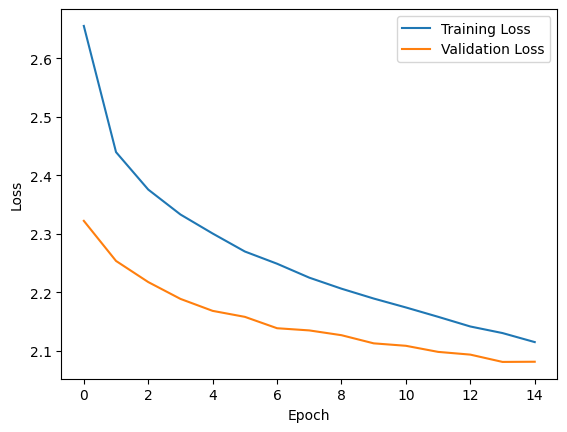

In [19]:
# Plot the loss
plot_loss(history)

### Inference

In [20]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

model_name = 'Jammal7/t5-small-finetuned-Big-Patents'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Jammal7/t5-small-finetuned-Big-Patents.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [21]:
document = df['test'][5]['description']
if 't5' in model_name: 
    document = "summarize: " + document
tokenized = tokenizer([document], return_tensors='np')
out = model.generate(**tokenized, max_length=128)

Token indices sequence length is longer than the specified maximum sequence length for this model (5684 > 512). Running this sequence through the model will result in indexing errors


In [22]:
with tokenizer.as_target_tokenizer():
    print(tokenizer.decode(out[0]))

<pad> A pressure diffuser for a pulp assembly includes a plurality of segments of the bearing cylinder wherein the segments are arranged side-by-side to form the bearing cylinder; and each of said segments includes a first region formed of a hard material and a second annular section formed of a soft material, wherein as the soft material is softer than the hard material, the hardness of the first material is sufficient to resist damage due to sand, rocks and other impurity particles in the pulp from migrating through the gap between the bearing cylinder and the</s>


## Text Summarization Pipeline

In [23]:
sample_text = df['test'][5]['description'][:1988]

In [24]:
sample_text

'RELATED APPLICATION \n       [0001]    This applications claims priority to U.S. Provisional Patent Application Ser. No. 61/140,467 filed Dec. 23, 2008, the entirety of which application is incorporated by reference. \n     \n    \n     BACKGROUND \n       [0002]    The invention disclosed herein relates generally to pressure diffusers for washing pulp and particularly relates to upper and lower cylindrical bearings between a moving screen assembly and stationary bearing cylinders in the pressure diffuser. \n         [0003]    The term “pulp” generally refers to comminuted cellulosic material, such as wood chips that have been processed in a digester to separate the fibers in the wood. Chemicals, e.g., liquor, are injected into the digester vessel to process the pulp. After the pulp is discharged from the digester vessel, the pulp may have residual amounts of chemicals. \n         [0004]    The pulp flow from the digester vessel to a pressurized diffuser that washes the pulp to remove

### BART

In [25]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)

In [26]:
pipe_out

[{'summary_text': 'This applications claims priority to U.S. Provisional Patent Application Ser. No. 61/140,467 filed Dec. 23, 2008. The term “pulp” generally refers to comminuted cellulosic material, such as wood chips that have been processed in a digester to separate the fibers in the wood.'}]